<a href="https://colab.research.google.com/github/ninadcpa/DSC630/blob/main/WEEK7_HOTEL_CASE_STUDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 Assignment - Create Optimal Hotel Recommendations

@author - Ninad Patkhedkar

In [1]:
# This code is written for mounting code folder checked out from github on google drive
# All assignment code will be maintained inside folder "DSC630"

from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DSC630')
os.chdir('/content/drive/MyDrive/Colab Notebooks/DSC630')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Online travel agencies are scrambling to meet the artificial intelligence driven personalization standard set by companies like Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.  

The data set can be found at Kaggle: Expedia Hotel Recommendations. To get started, I would suggest exploring the file train.csv, which contains the logs of user behavior.  There is another file named destinations.csv, which contains information related to hotel reviews made by users. There is a lot of data here, and making an accurate prediction is rather difficult, e.g., simply running a standard prediction algorithm will probably yield below 10% accuracy. Stary by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv). Then, build at least two prediction models from the training set, and report the accuracies on the test set. As I mentioned, this is a difficult problem, so be creative with your solutions. You might want to try building your own predictor rather than a standard predictor model, e.g., a random forest.  The purpose of this project is not necessarily to get great results but to understand the nuances and challenges of such problems.

In [2]:
!pip install datatable

In [3]:
import pandas as pd
#!pip install datatable
import datatable as dt
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore") 
import random

Dataset is very large in size. I am using free edition of cloud notebook which crashes for such large dataset.

I will pick random set of 10000 records for analysis.

In [4]:
################### Read train.csv file ###############################################
file = 'expedia/train.csv'
n = 37670293 # number of records in file
s = 100000 # desired sample size
skip = sorted(random.sample(range(n), n-s))
colNames = pd.read_csv(file, nrows=1).columns
train = pd.read_csv(file, skiprows=skip, names=colNames).dropna()
#train = pd.read_csv('expedia/train.csv', sep=',').dropna()
#train = train.sample(frac=0.01, random_state=99)
print('The shape of train dataset is:',train.shape,'\n')

The shape of train dataset is: (64100, 24) 



Data contains 64093 observations and 24 features.
Lets explore and summerize the data

In [5]:
train.sample(10)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
21596,2014-02-26 13:36:25,2,3,66,331,54953,135.7212,1107247,0,0,9,2014-02-27,2014-02-28,1,0,1,25256,1,0,1,2,50,440,91
34103,2014-06-02 08:53:04,2,3,66,220,5686,24.6512,1197424,0,0,9,2014-12-22,2014-12-29,4,0,1,8268,1,0,1,2,50,682,18
15752,2014-04-24 17:56:38,2,3,66,351,36508,8000.9863,1051038,1,0,2,2014-05-12,2014-05-14,2,0,1,6581,6,0,1,3,171,61,21
9619,2014-03-14 06:32:13,2,3,66,351,44304,3930.7384,985396,0,1,4,2014-03-18,2014-03-21,1,0,1,8745,1,0,1,6,204,27,86
85085,2014-06-02 12:50:59,8,4,77,824,15015,7508.7798,1161409,0,0,0,2014-10-23,2014-10-27,2,0,1,8254,1,0,2,2,50,365,37
13485,2014-10-21 07:57:55,2,3,66,220,14656,188.1665,18153,0,0,9,2014-11-01,2014-11-02,3,0,1,13441,4,0,3,2,50,682,77
71050,2014-05-31 23:03:03,2,3,66,174,35675,66.8354,640271,0,0,9,2014-06-02,2014-06-05,1,0,1,12002,1,0,1,2,50,967,13
73317,2014-06-13 07:52:22,2,3,66,220,40105,236.2593,550251,0,0,1,2014-07-05,2014-07-06,2,0,1,19363,1,0,1,2,50,585,32
93883,2014-03-31 17:48:11,2,3,66,174,30698,1214.0368,1081084,1,1,0,2014-06-10,2014-06-17,2,0,1,8824,1,0,1,4,8,118,17
83451,2013-08-19 17:29:33,2,3,66,351,36508,1707.7704,721592,1,1,0,2013-11-29,2013-12-06,2,0,1,11439,1,0,2,4,163,1503,52


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64100 entries, 0 to 100000
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  64100 non-null  object 
 1   site_name                  64100 non-null  int64  
 2   posa_continent             64100 non-null  int64  
 3   user_location_country      64100 non-null  int64  
 4   user_location_region       64100 non-null  int64  
 5   user_location_city         64100 non-null  int64  
 6   orig_destination_distance  64100 non-null  float64
 7   user_id                    64100 non-null  int64  
 8   is_mobile                  64100 non-null  int64  
 9   is_package                 64100 non-null  int64  
 10  channel                    64100 non-null  int64  
 11  srch_ci                    64100 non-null  object 
 12  srch_co                    64100 non-null  object 
 13  srch_adults_cnt            64100 non-null  in

Most of the fields are numeric.
Lets descrivbe the data.

In [7]:
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,6.410000e+04,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000,64100.000000
mean,6.209672,2.903167,88.033432,310.806193,28049.239594,1979.080195,5.961939e+05,0.139173,0.245445,5.991856,2.036100,0.347348,1.100047,14366.092590,2.621076,0.083994,1.471981,2.897660,74.143354,618.709922,49.840296
std,8.988494,0.537636,54.669241,144.429626,16530.739081,2235.803718,3.428237e+05,0.346130,0.430354,3.737168,0.894979,0.751118,0.420118,10739.993786,2.165781,0.277381,1.163928,1.498105,53.847556,473.890122,29.094798
min,2.000000,0.000000,0.000000,135.000000,0.000000,0.025300,4.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,66.000000,174.000000,14656.000000,312.823950,3.004685e+05,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,8267.000000,1.000000,0.000000,1.000000,2.000000,50.000000,245.000000,25.000000
50%,2.000000,3.000000,66.000000,318.000000,27655.000000,1156.988550,5.926710e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,11334.000000,1.000000,0.000000,1.000000,2.000000,50.000000,628.000000,48.000000
75%,2.000000,3.000000,66.000000,363.000000,43026.000000,2558.597075,8.927922e+05,0.000000,0.000000,9.000000,2.000000,0.000000,1.000000,17859.000000,5.000000,0.000000,2.000000,4.000000,77.000000,701.000000,73.000000
max,43.000000,4.000000,215.000000,1021.000000,56507.000000,11825.162100,1.198748e+06,1.000000,1.000000,10.000000,9.000000,9.000000,8.000000,64982.000000,9.000000,1.000000,28.000000,6.000000,212.000000,2117.000000,99.000000


To perform EDA, lets update some date/time related fields.

In [8]:
train["date_time"] = pd.to_datetime(train["date_time"]) 
train["year"] = train["date_time"].dt.year  
train["month"] = train["date_time"].dt.month
train['srch_ci']=pd.to_datetime(train['srch_ci'],infer_datetime_format = True,errors='coerce')
train['srch_co']=pd.to_datetime(train['srch_co'],infer_datetime_format = True,errors='coerce')
train['plan_time'] = ((train['srch_ci']- train['date_time'])/np.timedelta64(1,'D')).astype(float)
train['hotel_nights']=((train['srch_co']-train['srch_ci'])/np.timedelta64(1,'D')).astype(float)
cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id']
train.drop(cols_to_drop, axis=1, inplace=True)
train.sample(10)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
59972,34,3,205,354,41949,117.9308,0,0,9,6,0,2,27077,6,0,1,2,50,641,50,2013,2,28.171019,1.0
42849,8,4,77,977,46771,5076.8156,0,0,1,3,0,1,43595,4,0,3,3,106,757,61,2013,4,81.142060,1.0
17261,2,3,66,220,47307,4387.4968,0,0,9,3,0,1,8255,1,1,1,6,77,20,15,2014,3,48.373646,1.0
49593,2,3,66,143,49966,159.8996,0,0,9,1,0,1,4887,3,0,1,2,50,350,91,2014,8,6.430093,1.0
18004,2,3,66,226,20170,139.6035,0,0,0,2,0,1,17859,1,0,1,2,50,427,51,2014,10,7.785891,1.0
86887,2,3,66,174,40789,5790.0763,0,1,0,4,0,3,8255,1,0,1,6,77,20,15,2013,7,149.466157,7.0
85527,2,3,66,311,30031,2371.8842,0,1,9,2,0,1,8250,1,0,4,2,50,628,24,2014,2,34.630023,4.0
67820,2,3,66,363,31848,5699.4821,0,0,9,2,0,1,8226,1,0,1,5,100,1446,46,2014,7,271.337755,3.0
39406,2,3,66,442,23459,918.6817,0,1,0,1,0,1,8230,1,0,1,2,50,637,94,2014,10,15.002523,3.0
56234,2,3,66,174,9821,7311.7507,0,0,9,3,0,3,15799,5,1,1,3,99,1033,46,2013,7,21.388380,1.0


Now lets plot Booking Class and its Frequency.

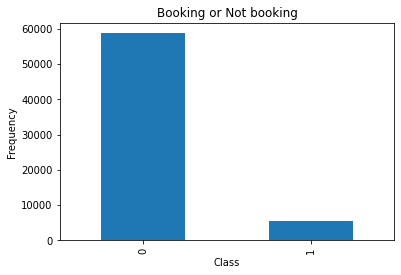

In [9]:
########################## Balance the datasets by downsampling ########################################
count_classes = pd.value_counts(train['is_booking'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Now lets check how many clicks actually turned into actual bookings.

In [10]:
booking_indices = train[train.is_booking == 1].index
random_indices = np.random.choice(booking_indices, len(train.loc[train.is_booking == 1]), replace=False)
booking_sample = train.loc[random_indices]
not_booking = train[train.is_booking == 0].index
random_indices = np.random.choice(not_booking, sum(train['is_booking']), replace=False)
not_booking_sample = train.loc[random_indices]
df_new = pd.concat([not_booking_sample, booking_sample], axis=0)
print("Percentage of not booking clicks: ", len(df_new[df_new.is_booking == 0])/len(df_new))
print("Percentage of booking clicks: ", len(df_new[df_new.is_booking == 1])/len(df_new))
print("Total number of records in resampled data: ", len(df_new))

Percentage of not booking clicks:  0.5
Percentage of booking clicks:  0.5
Total number of records in resampled data:  10768


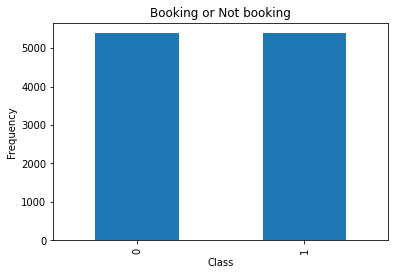

In [11]:
count_classes = pd.value_counts(df_new['is_booking'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Now lets try to construct various Models and find their accuracy. For this purpose will use sklearn library.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

First I will perfom PCA

[[-0.4566472   0.18142057 -0.42071168 ... -1.19846553 -0.18109712
   1.35161026]
 [-0.4566472   0.18142057 -0.42071168 ...  1.24382759 -0.14101789
  -0.69437825]
 [-0.4566472   0.18142057 -0.42071168 ... -1.80903881  2.11402311
   0.84011313]
 ...
 [ 0.20975735  2.15071164 -0.21960731 ...  0.32796767 -0.59416387
  -0.18288112]
 [-0.4566472   0.18142057 -0.42071168 ... -1.80903881 -0.40378335
   0.84011313]
 [ 0.54295962  0.18142057  2.1205163  ...  0.32796767  0.56839495
  -0.18288112]]
[ 10.1  18.7  25.9  32.5  38.3  43.6  48.5  53.3  58.1  62.7  67.2  71.5
  75.7  79.8  83.5  86.9  89.7  92.2  94.7  96.8  98.7 100. ]


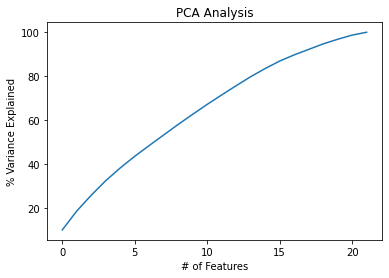

In [14]:
df_booking = df_new.loc[df_new['is_booking'] == 1]
X = df_booking.drop([ 'hotel_cluster', 'is_booking'], axis=1)
y = df_booking.hotel_cluster

scaler = StandardScaler()
X=scaler.fit_transform(X)
print(X)

pca = PCA(n_components=22)
pca.fit(X)

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
print(var)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.show()

In [15]:
print('\nThe correlation coefficients are:\n',df_booking.corr()['hotel_cluster'])


The correlation coefficients are:
 site_name                   -0.000499
posa_continent              -0.014877
user_location_country       -0.013457
user_location_region         0.025151
user_location_city          -0.004096
orig_destination_distance    0.045373
is_mobile                   -0.003060
is_package                   0.033964
channel                      0.011887
srch_adults_cnt              0.022294
srch_children_cnt           -0.007768
srch_rm_cnt                  0.003990
srch_destination_id         -0.004577
srch_destination_type_id    -0.031759
is_booking                        NaN
cnt                         -0.003449
hotel_continent              0.031893
hotel_country               -0.000879
hotel_market                 0.017631
hotel_cluster                1.000000
year                         0.010897
month                        0.000017
plan_time                    0.013038
hotel_nights                 0.034800
Name: hotel_cluster, dtype: float64


Now lets read destination.csv file and perform PCA

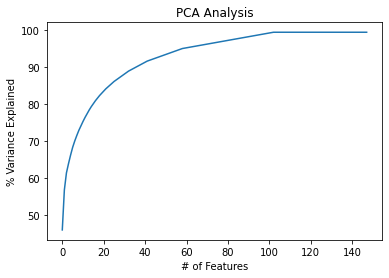

          0         1         2  ...        18        19  srch_destination_id
0 -0.044268  0.169419  0.032515  ... -0.026337 -0.119157                    0
1 -0.440761  0.077405 -0.091572  ...  0.026824 -0.002881                    1
2  0.001033  0.020677  0.012107  ...  0.037228 -0.031114                    2
3 -0.480467 -0.040345 -0.019320  ...  0.001498 -0.016325                    3
4 -0.207253 -0.042694 -0.011743  ... -0.017707  0.023287                    4

[5 rows x 21 columns]


In [18]:
dest = pd.read_csv('expedia/destinations.csv')
from sklearn.decomposition import PCA


pca = PCA(n_components=148)
pca.fit(dest[["d{0}".format(i + 1) for i in range(149)]])

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.show()

pca = PCA(n_components=20)
dest_small = pca.fit_transform(dest[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = dest["srch_destination_id"]
print(dest_small.head())

Now creating Test dataset by splitting Training dataset

In [19]:
X = df_booking.drop([ 'hotel_cluster', 'is_booking'], axis=1)
y = df_booking.hotel_cluster
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3607, 22)
(1777, 22)
(3607,)
(1777,)


Use RandomForest classifier to test usability/importance of features

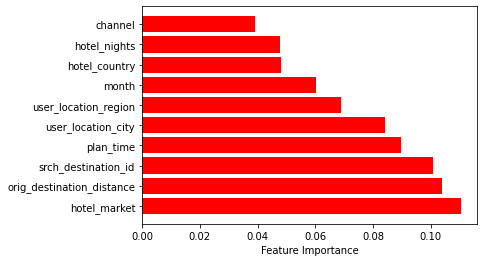

In [20]:
rf_tree = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
rf_tree.fit(X_train,y_train)
importance = rf_tree.feature_importances_
indices=np.argsort(importance)[::-1][:10]
importance[indices]

plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10),X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

Hotel Market and Original destination distance appear to be very important.

In [21]:
# Some more data prep
pieces = [df_new.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
print(agg.head())

agg['score'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
print(agg.head())

agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='score').reset_index()
print(agg_pivot.head())

df = pd.merge(df_new, dest_small, how='left', on='srch_destination_id')
# print(df.head())
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
df.fillna(0, inplace=True)

print(df.shape)
# print(df.head())

df = df.loc[df['is_booking'] == 1]

X = df.drop([ 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

                                                              sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          42               1      1
                                               48               1      1
                                               76               0      1
21                  77            1454         82               1      1
24                  50            606          11               0      1
   srch_destination_id  hotel_country  hotel_market  ...  sum     count     score
0                    8             50           416  ...  0.5  0.333333  0.465116
1                    8             50           416  ...  0.5  0.333333  0.465116
2                    8             50           416  ...  0.0  0.333333  0.069767
3                   21             77          1454  ...  1.0  1.000000  1.000000
4                   24             50           606  ...  0.0  0.250000  0.0476

###1 . Random Forest Classifier

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

######################## Random Forest Classifier #################################
rf_tree = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
rf_tree.fit(X_train,y_train)

accuracy_randomforest = rf_tree.score(X_test,y_test)
print('\nAccuracy for random classifier model is:',accuracy_randomforest)


(3607, 142)
(1777, 142)
(3607,)
(1777,)

Accuracy for random classifier model is: 0.31907709622960045


###2. K-Nearest-Neighbor Classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier
clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
accuracy_knn=np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy'))
print('\nAccuracy for KNN classifier model is:',accuracy_knn)


Accuracy for KNN classifier model is: 0.39340720221606645


###3. Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
accuracy_LR=np.mean(cross_val_score(clf, X_train, y_train, cv=10))
print('\nAccuracy for Logistic Regression classifier model is:',accuracy_LR)


Accuracy for Logistic Regression classifier model is: 0.3928554939981532


###4. Support Vector Machines Classifier

In [25]:
from sklearn import svm
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
accuracy_SVM=np.mean(cross_val_score(clf, X_train, y_train, cv=10))
print('\nAccuracy for SVM classifier model is:',accuracy_SVM)


Accuracy for SVM classifier model is: 0.4244629116651277


Overall all 4 models have accuracy ranging between 0.31 to 0.42.

SVM model has the highest accuracy of 0.42 hence that Model would be used to recommend Hotel for booking.